## Goals: Display waterflows predictions

This notebook aims to display waterflows prediction intervals, for test stations of spatial split and spatio temporal split.

# 1. Data Import and Setup

Imports necessary libraries, sets up environment paths.

In [1]:
from math import sqrt
import sys
import pandas as pd
import os
import numpy as np
import joblib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..','..','..','..')))

from src.utils.model import load_models_auto
from src.utils.plots import plot_water_flow_predictions


Defines constants :
* INPUT_DIR must be the same as the one defined in *00 Preprocessing/Feature Engineering*.
* MODEL_DIR must be the same as the one defined in *Splited Dataset/02 -Training*.

In [2]:
SEED = 42
USE_AUTO_SCAN = True
NUMBER_OF_WEEK = 4
INPUT_DIR = "../../../../data/input/"
MODEL_DIR = "../../../../models/exploration/"
ALPHA = 0.1
MODEL = "qrf"

# columns to drop : target at different horizon, station_code, and features removed from Feature Selection
TO_DROP = ["water_flow_week1", "station_code", "water_flow_week2", "water_flow_week3", "water_flow_week4"]

### 2. Data & Models Loading

#### a. Loading of the baseline datasets.

In [3]:
# load the dataset
ds_train = pd.read_csv(f"{INPUT_DIR}ds_train.csv")
ds_test_spatio_temporal = pd.read_csv(f"{INPUT_DIR}ds_test_spatio_temporal.csv")
ds_test_temporal = pd.read_csv(f"{INPUT_DIR}ds_test_temporal.csv")

ds_train["ObsDate"] = pd.to_datetime(ds_train["ObsDate"])
ds_test_spatio_temporal["ObsDate"] = pd.to_datetime(ds_test_spatio_temporal["ObsDate"])
ds_test_temporal["ObsDate"] = pd.to_datetime(ds_test_temporal["ObsDate"])

ds_train = ds_train.set_index("ObsDate")
ds_test_spatio_temporal = ds_test_spatio_temporal.set_index("ObsDate")
ds_test_temporal = ds_test_temporal.set_index("ObsDate")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [4]:
X_train = ds_train.drop(columns=TO_DROP)
y_train = {}
y_train[0] = ds_train["water_flow_week1"]
for i in range(1, NUMBER_OF_WEEK):
    y_train[i] = ds_train[f"water_flow_week{i+1}"]

X_test_spatio_temporal = ds_test_spatio_temporal.drop(columns=TO_DROP)
y_test_spatio_temporal = {}
for i in range(0, NUMBER_OF_WEEK):
    y_test_spatio_temporal[i] = ds_test_spatio_temporal[f"water_flow_week{i+1}"]

X_test_temporal = ds_test_temporal.drop(columns=TO_DROP)
y_test_temporal = {}
for i in range(0, NUMBER_OF_WEEK):
    y_test_temporal[i] = ds_test_temporal[f"water_flow_week{i+1}"]

mapie_enbpi = {}
mapie = {}
qrf = {}
mapie_aci = {}



#### b. Loading of the model to analyse

Models must be trained on `02 Training`.

In [5]:
# Function to create a predictor for a specific week
def create_predict_function(model_list, i, model):
    def predict(X):
        if model == "mapie":
            return model_list[i].predict(X)[0]
        elif model == "qrf":
            return model_list[i].predict(X)
        elif model == "emb":
            print(model_list[i+1][0])
            preds_ebm = np.array([m.predict(X_test) for m in model[i+1][0]])  # shape (n_ensembles, n_samples)
            y_pred_ebm = preds_ebm.mean(axis=0)
            y_pred_ebm = np.array(y_pred_ebm)
            return y_pred_ebm
    return predict

# Function to create a quantile predictor for a specific week
def create_quantile_function(model_list, i, model):
    def predict_quantile(X):
        if model == "mapie":
            return model_list[i].predict(X)[1]
        elif model == "qrf":
            return model_list[i].predict(X, quantiles=[ALPHA/2, 1-ALPHA/2])
        elif model == "emb":
            print(model_list[i+1][0])
            preds_ebm = np.array([m.predict(X_test) for m in model_list[i+1][0]])  # shape (n_ensembles, n_samples)
            ebm_lower = np.percentile(preds_ebm, 5, axis=0)
            ebm_upper = np.percentile(preds_ebm, 95, axis=0) 
            y_pis_ebm = [ebm_lower, ebm_upper]
            y_pis_ebm = np.array(y_pis_ebm)
            y_pis_ebm = y_pis_ebm.T
            return y_pis_ebm        
    return predict_quantile

# Load models based on conditions
loaded_models = []
if MODEL == "mapie":
    if USE_AUTO_SCAN:
        loaded_models = load_models_auto("mapie_quantile", MODEL_DIR)
    else:
        loaded_models.append(joblib.load("../../models/mapie_quantile_2025-01-17_15-15-04_week0.pkl"))
        loaded_models.append(joblib.load("../../models/mapie_quantile_2025-01-17_15-15-11_week1.pkl"))
        loaded_models.append(joblib.load("../../models/mapie_quantile_2025-01-17_15-15-17_week2.pkl"))

elif MODEL == "qrf":
    if USE_AUTO_SCAN:
        loaded_models = load_models_auto("qrf_quantile", MODEL_DIR )
    else:
        loaded_models.append(joblib.load("../../models/qrf_quantile_2025-01-17_15-15-04_week0.pkl"))
        loaded_models.append(joblib.load("../../models/qrf_quantile_2025-01-17_15-15-11_week1.pkl"))
        loaded_models.append(joblib.load("../../models/qrf_quantile_2025-01-17_15-15-17_week2.pkl"))

elif MODEL == "emb":
    if USE_AUTO_SCAN:
        loaded_models = load_models_auto("ebm_ensemble", MODEL_DIR)
    else:
        loaded_models.append(joblib.load("../../models/EBM_ensemble_2025-01-17_15-15-04_week0.pkl"))
        loaded_models.append(joblib.load("../../models/EBM_ensemble_2025-01-17_15-15-11_week1.pkl"))
        loaded_models.append(joblib.load("../../models/EBM_ensemble_2025-01-17_15-15-17_week2.pkl"))
        loaded_models.append(joblib.load("../../models/EBM_ensemble_2025-01-17_15-15-17_week3.pkl"))


### 3. Predictions displayed

In the following cells we display predictions on the test station from the temporal and spatio temporal Split from `01 - Dataset Split`.

#### a. Temporal Split


In [6]:
y_pred_t_quantile = {}
y_pred_t = {} 


predict_adjusted = create_predict_function(loaded_models, 0, MODEL)
quantile_adjusted = create_quantile_function(loaded_models, 0, MODEL)


y_pred_t = predict_adjusted(X_test_temporal)
y_pred_t_quantile = quantile_adjusted(X_test_temporal)


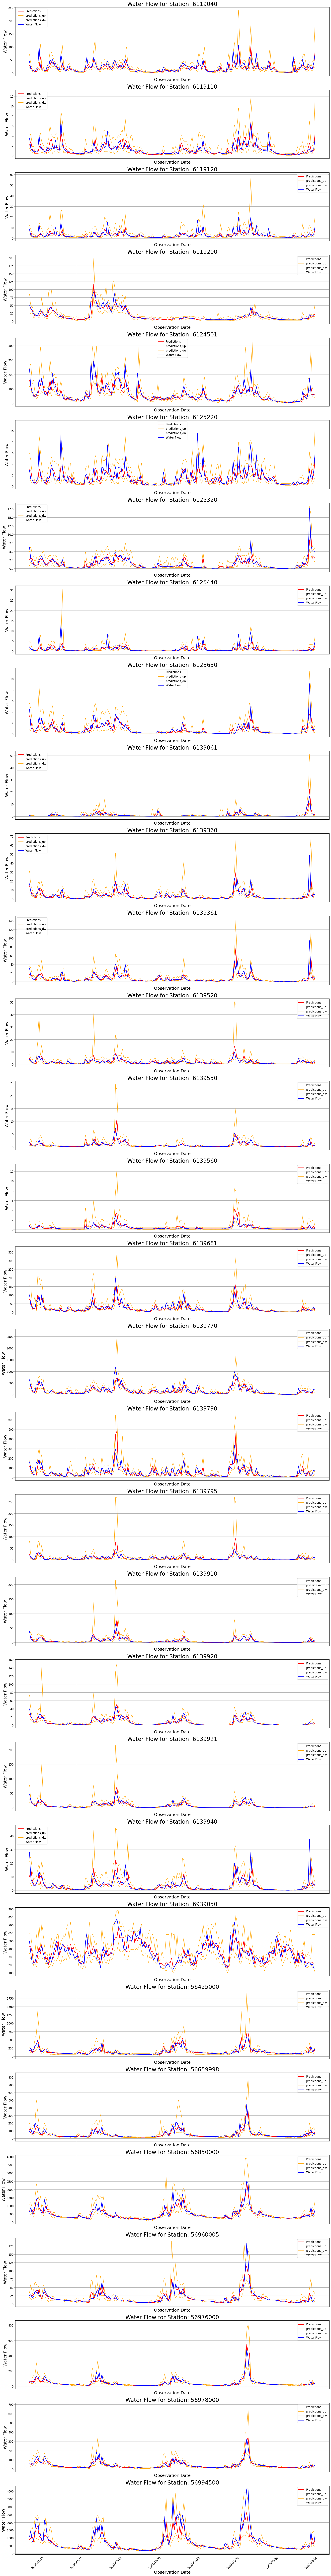

In [7]:
plot_water_flow_predictions(ds_test_temporal, y_pred_t, y_pred_t_quantile, "test", save = False, display = True)

#### a. Spatio-Temporal Split


In [8]:
y_pred_st = predict_adjusted(X_test_spatio_temporal)
y_pred_st_quantile = quantile_adjusted(X_test_spatio_temporal)

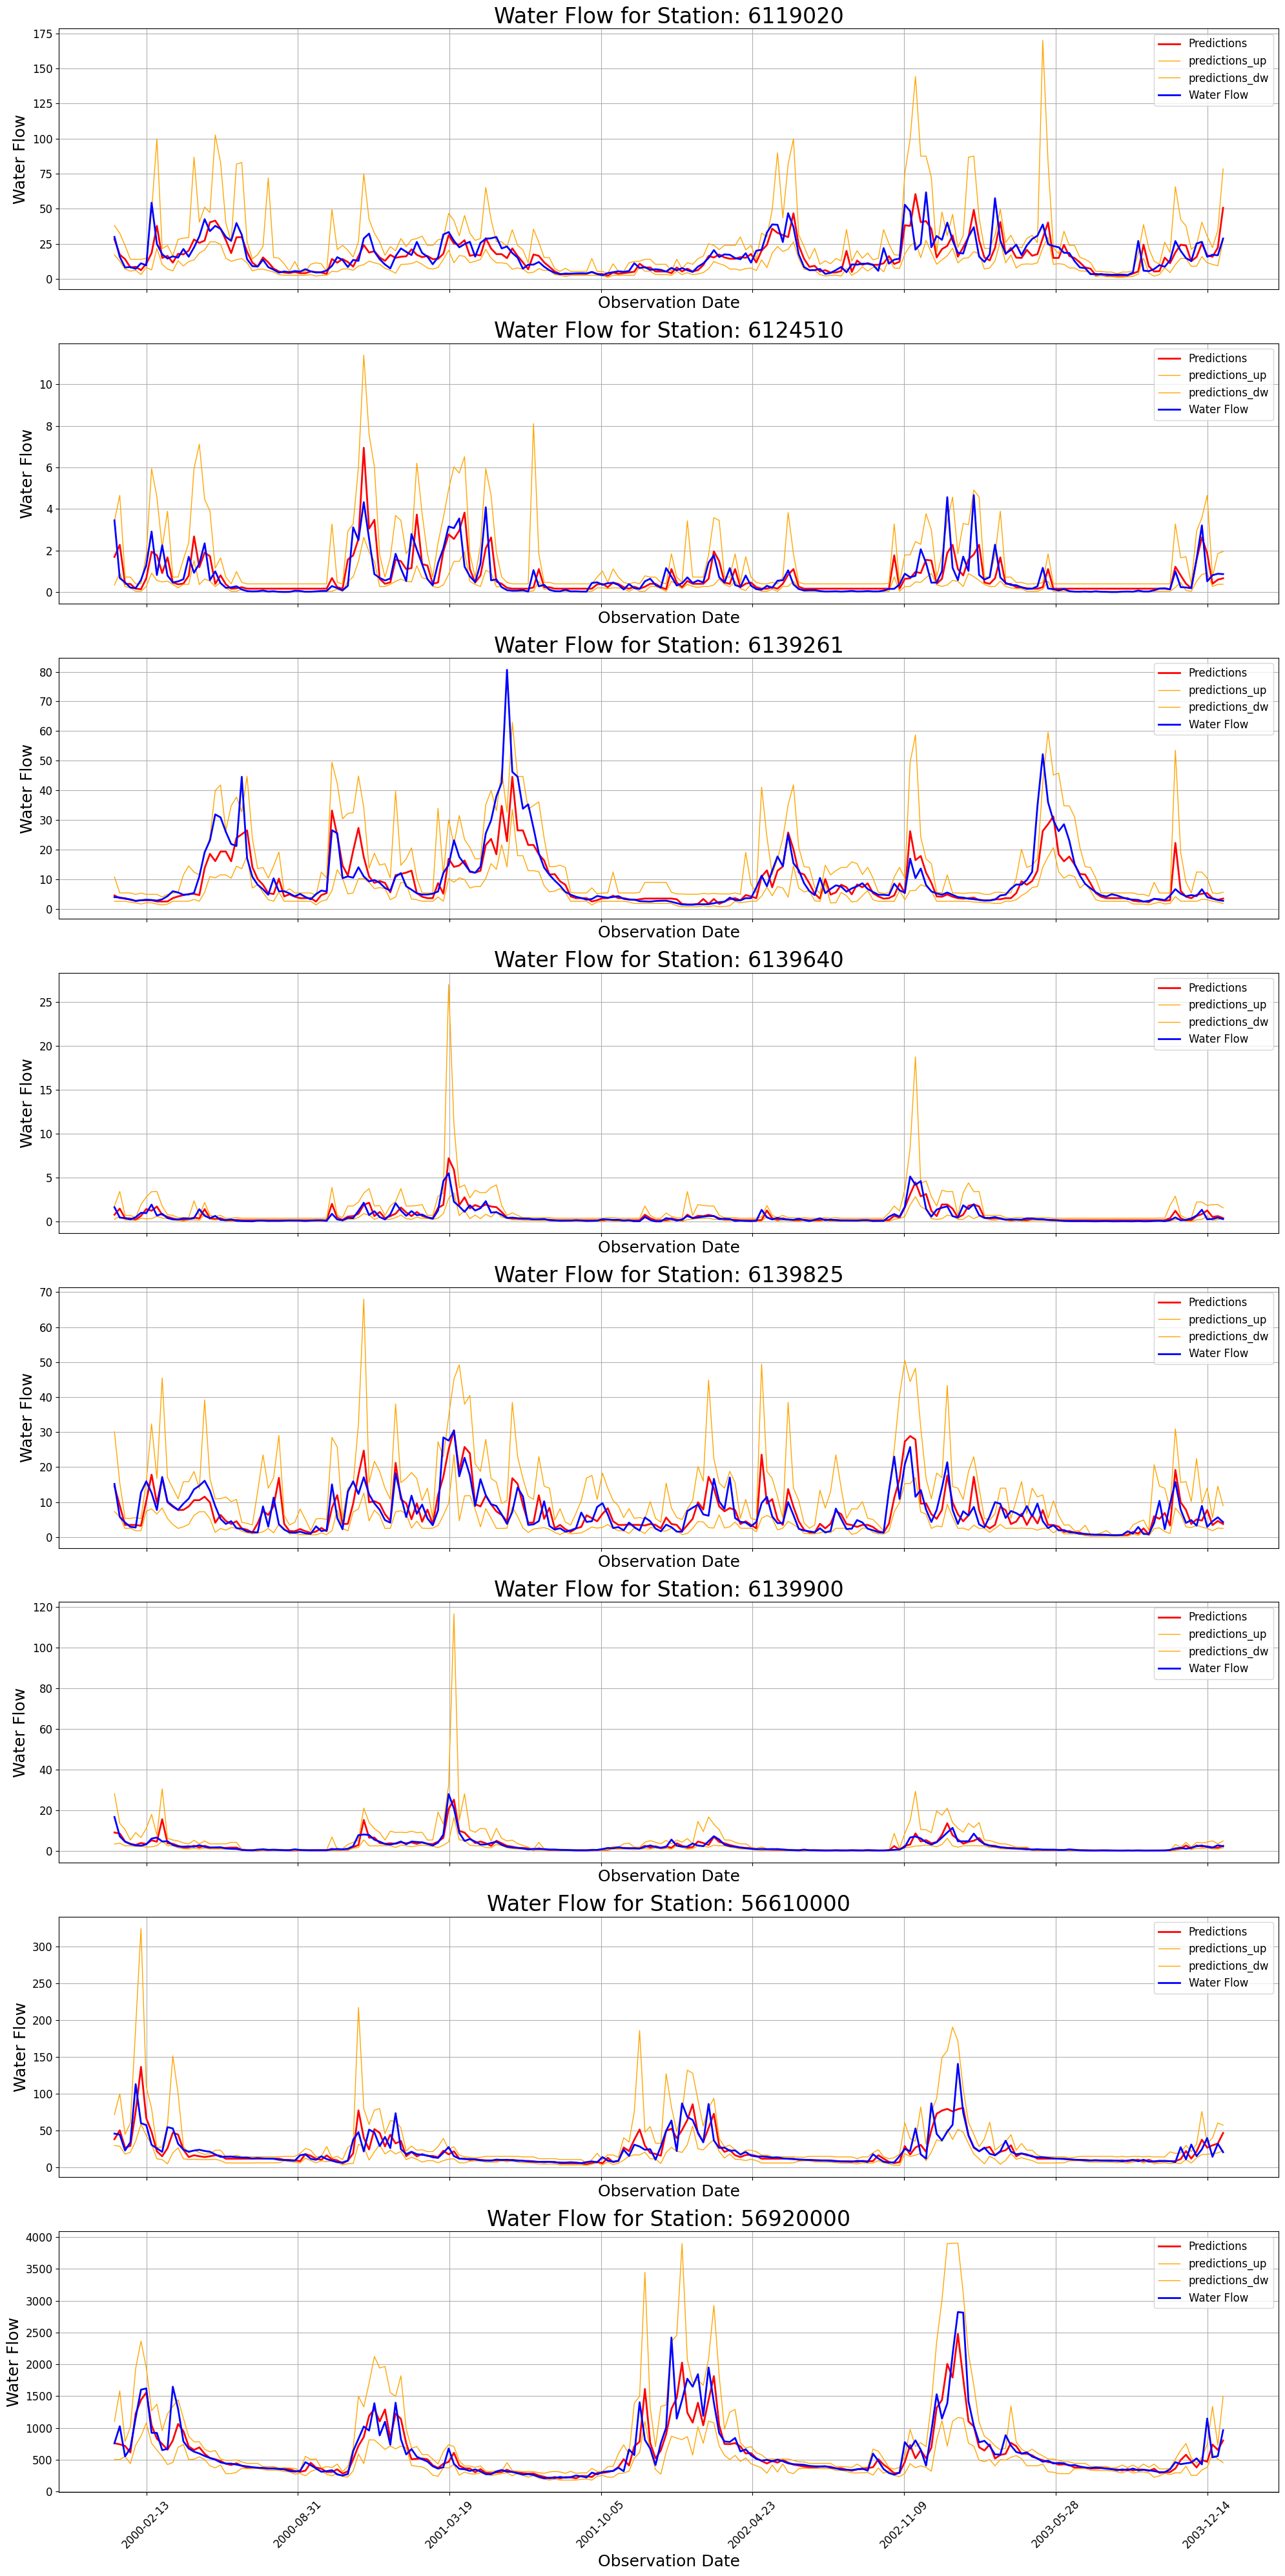

In [9]:
plot_water_flow_predictions(ds_test_spatio_temporal, y_pred_st, y_pred_st_quantile, "test", save = False, display = True)